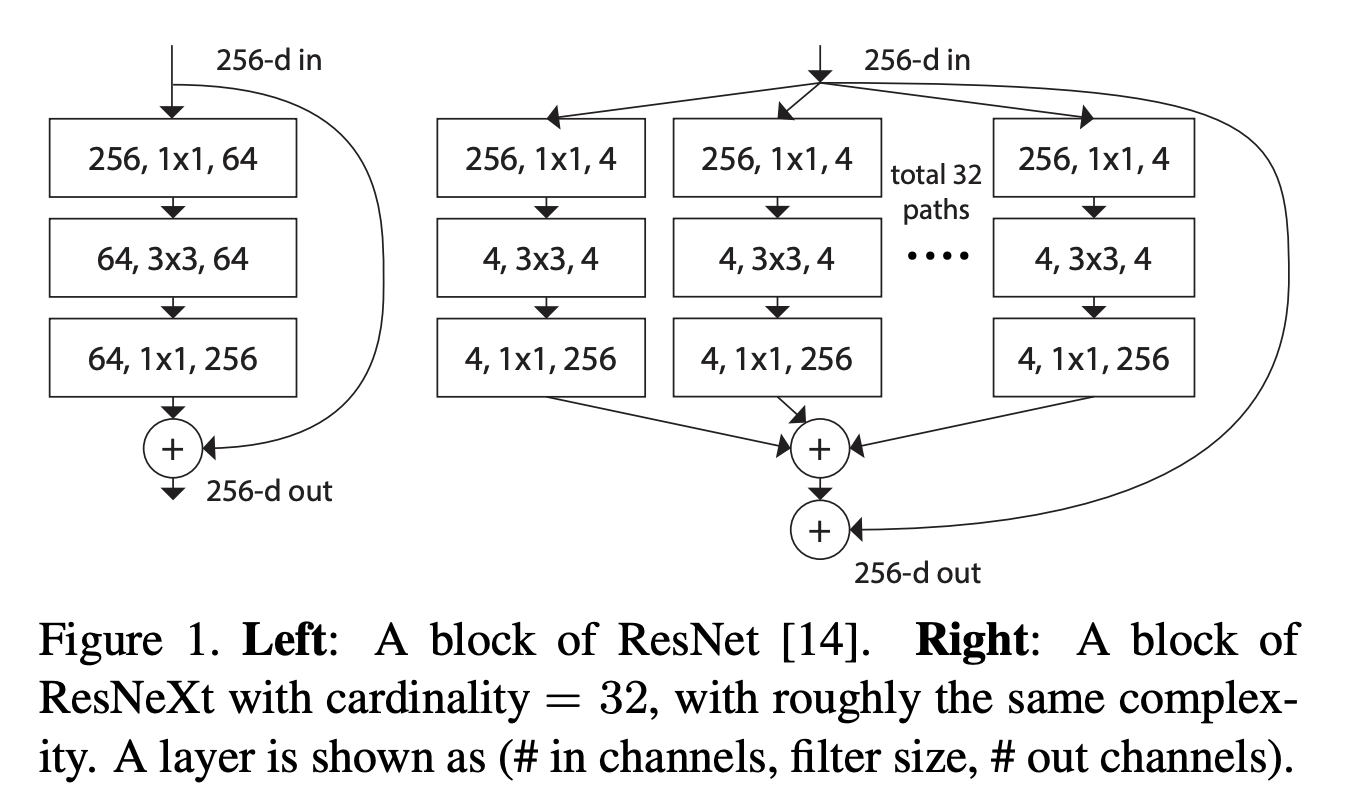

In [1]:
import tensorflow as tf

In [2]:
class BasicBlock_C(tf.keras.layers.Layer):
    def __init__(self, in_planes, bottleneck_width=4, cardinality=32, stride=1, expansion=2):
        super(BasicBlock_C, self).__init__()
        inner_width = cardinality * bottleneck_width
        self.expansion = expansion

        self.basic = tf.keras.Sequential([
            tf.keras.layers.Conv2D(inner_width, kernel_size=1, strides=1, padding='valid', use_bias=False,
                                   input_shape=(None, None, in_planes),
                                   kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(inner_width, kernel_size=3, strides=stride, padding='same', groups=cardinality, use_bias=False,
                                   kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.ReLU(),
            tf.keras.layers.Conv2D(inner_width * self.expansion, kernel_size=1, strides=1, padding='valid', use_bias=False,
                                   kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
            tf.keras.layers.BatchNormalization()
        ])

        self.shortcut = tf.keras.Sequential()
        if stride != 1 or in_planes != inner_width * self.expansion:
            self.shortcut = tf.keras.Sequential([
                tf.keras.layers.Conv2D(inner_width * self.expansion, kernel_size=1, strides=stride, padding='same', use_bias=False,
                                       kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4)),
                tf.keras.layers.BatchNormalization()
            ])

        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()

    def call(self, X, training=False):
        out = self.basic(X)
        out += self.shortcut(X)
        out = self.bn1(out)
        out = self.relu(out)
        return out

In [3]:
class ResNeXt(tf.keras.Model):
    def __init__(self, num_blocks, cardinality, bottleneck_width, input_shape, num_classes, expansion=2):
        super(ResNeXt, self).__init__()
        self.cardinality = cardinality
        self.bottleneck_width = bottleneck_width
        self.in_planes = 64
        self.expansion = expansion

        self.conv1 = tf.keras.layers.Conv2D(self.in_planes, kernel_size=3, strides=1, padding='same',
                                            kernel_initializer='he_normal', kernel_regularizer=tf.keras.regularizers.L2(1e-4))
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.relu = tf.keras.layers.ReLU()
        self.max_pool = tf.keras.layers.MaxPooling2D(pool_size=3, strides=2, padding='same')
        self.layer1 = self._make_layer(num_blocks[0],1)
        self.layer2 = self._make_layer(num_blocks[1],2)
        self.layer3 = self._make_layer(num_blocks[2],2)
        self.layer4 = self._make_layer(num_blocks[3],2)
        self.GAP = tf.keras.layers.GlobalAveragePooling2D()
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')
        if input_shape:
            self.build((None, *input_shape))

    def call(self, X):
        out = self.relu(self.bn1(self.conv1(X)))
        out = self.max_pool(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.GAP(out)
        out = self.dropout(out)
        out = self.fc(out)
        
        return out
    
    def _make_layer(self, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []

        for stride in strides:
            layers.append(BasicBlock_C(self.in_planes, self.bottleneck_width, self.cardinality, stride, self.expansion))
            self.in_planes = self.expansion * self.bottleneck_width * self.cardinality
        self.bottleneck_width *= 2

        return tf.keras.Sequential(layers)

In [4]:
def resnext20_8x32d():
    return ResNeXt(num_blocks=[2, 2, 2, 2], cardinality=8, bottleneck_width=32,
                   input_shape=(32, 32, 3), num_classes=10)